In [46]:
import pandas as pd

# Load the IRS data (replace with your file path if local)
url = "https://www.irs.gov/pub/irs-soi/22zpallagi.csv"
df = pd.read_csv(url, encoding="ISO-8859-1", low_memory=False)

# Display first few rows
df.head()


,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,1,AL,0,1,659530.0,422590.0,71000.0,154700.0,610780.0,24340.0,...,0.0,0.0,63060.0,54280.0,543620.0,1559881.0,541480.0,1552563.0,2250.0,5031.0
1,1,AL,0,2,533640.0,276250.0,101050.0,141040.0,499310.0,15050.0,...,0.0,0.0,100320.0,130848.0,430380.0,1339883.0,427830.0,1329439.0,2780.0,8556.0
2,1,AL,0,3,304870.0,134050.0,109980.0,51600.0,286110.0,9600.0,...,0.0,0.0,88750.0,186002.0,216080.0,585162.0,212990.0,573080.0,4520.0,12589.0
3,1,AL,0,4,193020.0,56350.0,113100.0,19090.0,181390.0,4530.0,...,0.0,0.0,67040.0,189833.0,124860.0,403052.0,121760.0,388581.0,2840.0,12190.0
4,1,AL,0,5,315700.0,45000.0,252660.0,12180.0,297930.0,9000.0,...,140.0,63.0,138270.0,657283.0,177730.0,748507.0,169080.0,671684.0,10940.0,80141.0


In [47]:
# Convert ZIPCODE to numeric
df['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')

# Drop rows with invalid ZIP codes
df = df.dropna(subset=['zipcode'])
df = df[df['zipcode'] != 0]
df = df[df['zipcode'] != 99999]

# Rename important columns for easier reference
df.rename(columns={
    'A00100': 'Total_Income',
    'N02650': 'Business_Income',
    'N00300': 'Wages',
    'N00200': 'Interest_Income',
    'NUMRET': 'Returns_Filed',
}, inplace=True)

# Show cleaned data
df[['STATE', 'zipcode', 'Total_Income', 'Business_Income', 'Wages']].head()


,STATE,zipcode,Total_Income,Business_Income,Wages
6,AL,35004,15888.0,1260.0,220.0
7,AL,35004,49413.0,1320.0,240.0
8,AL,35004,61695.0,1000.0,240.0
9,AL,35004,53252.0,620.0,200.0
10,AL,35004,139477.0,1040.0,430.0


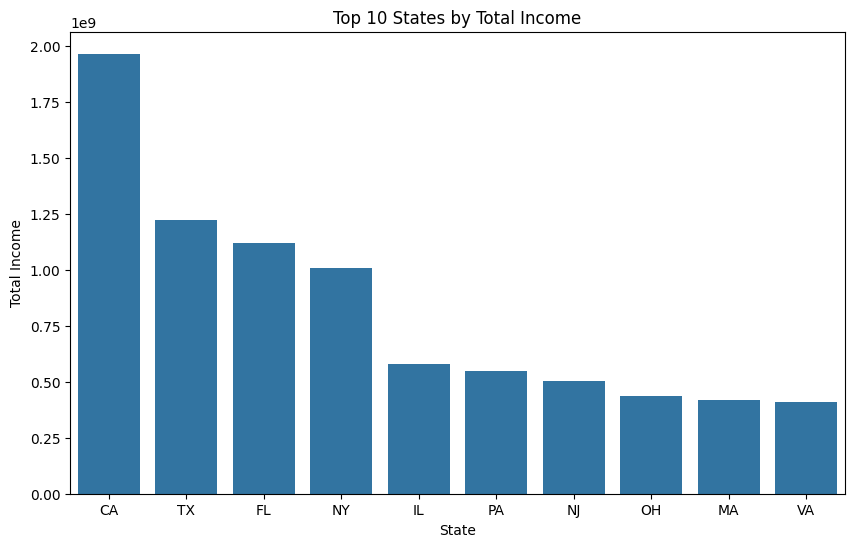

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 10 states by total income
top_states = df.groupby('STATE')['Total_Income'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_states.index, y=top_states.values)
plt.title('Top 10 States by Total Income')
plt.xlabel('State')
plt.ylabel('Total Income')
plt.show()


In [49]:
!pip install scikit-learn



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
# Correct column renaming (include NUMRET if not already renamed)
df.rename(columns={
    'A00100': 'Total_Income',         # Adjusted Gross Income
    'N02650': 'Business_Income',      # Net Business Income
    'N00300': 'Wages',                # Wage Income
    'NUMRET': 'Returns_Filed'         # Number of tax returns
}, inplace=True)



In [51]:
# Rename the correct columns
df.rename(columns={
    'A00100': 'Total_Income',
    'N02650': 'Business_Income',
    'N00300': 'Wages',
    'N1': 'Returns_Filed'  # <--- this is the key fix
}, inplace=True)

# Create Success Index
df['Success_Index'] = df['Business_Income'] + df['Wages']

# Drop NA from relevant features
model_df = df.dropna(subset=['Total_Income', 'Returns_Filed', 'Success_Index'])

# Train a simple regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = model_df[['Total_Income', 'Returns_Filed']]
y = model_df['Success_Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

print("Model Score on Test Set:", model.score(X_test, y_test))


Model Score on Test Set: 0.9806515508978965


In [52]:
top_zip = df[['STATE', 'zipcode', 'Total_Income', 'Business_Income', 'Wages']]
top_zip['Success_Score'] = top_zip['Business_Income'] + top_zip['Wages']
top_zip = top_zip.sort_values(by='Success_Score', ascending=False).head(20)

print(top_zip)


       STATE  zipcode  Total_Income  Business_Income    Wages  Success_Score
97088     NY    11355      356806.0          30810.0   3770.0        34580.0
96968     NY    11220      367121.0          28770.0   2750.0        31520.0
97160     NY    11368      271916.0          24330.0   1920.0        26250.0
97184     NY    11373      263114.0          23280.0   2690.0        25970.0
155411    WA    98052     6342427.0          12830.0  10620.0        23450.0
143342    TX    77449      287986.0          21360.0   1210.0        22570.0
95623     NY    10023    12563199.0          12100.0  10120.0        22220.0
14536     CA    95014     7504091.0          11970.0  10140.0        22110.0
143479    TX    77494     5297661.0          12850.0   8860.0        21710.0
96865     NY    11201     8110820.0          11780.0   9270.0        21050.0
96896     NY    11208      234590.0          18870.0   1470.0        20340.0
16383     CA    95747     1688879.0          11750.0   8330.0        20080.0

C:\Users\My PC\AppData\Local\Temp\ipykernel_62072\3389478422.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
!pip install uszipcode



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
import pandas as pd



# Load the ZIP-to-lat/lon dataset
zip_latlon = pd.read_csv("uszips.csv")  # Update path if needed

# Ensure ZIP code formats match (padded 5-digit strings)
top_zip['zipcode'] = top_zip['zipcode'].astype(str).str.zfill(5)
zip_latlon['zip'] = zip_latlon['zip'].astype(str).str.zfill(5)

# Merge to add latitude and longitude
top_zip = top_zip.merge(zip_latlon[['zip', 'lat', 'lng']], left_on='zipcode', right_on='zip')

# Drop any missing coordinates (if any)
top_zip.dropna(subset=['lat', 'lng'], inplace=True)


In [55]:
from urllib.request import urlopen
import json

# Load U.S. states center coordinates
state_coords = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/us-state-capitals.csv")

# Add state names as labels
for _, row in state_coords.iterrows():
    fig.add_trace(go.Scattergeo(
        lat=[row['Latitude']],
        lon=[row['Longitude']],
        text=row['State'],
        mode='text',
        showlegend=False,
        textfont=dict(size=10)
    ))


HTTPError: HTTP Error 404: Not Found

In [ ]:
import plotly.express as px

fig = px.scatter_geo(
    top_zip,
    lat='lat',
    lon='lng',
    color="Success_Score",
    size="Success_Score",
    hover_name="zipcode",
    scope="usa",
    title="Top ZIP Codes for Business Success in the USA"
)
fig.show()


In [ ]:
from uszipcode import SearchEngine

# Create search engine
search = SearchEngine(simple_zipcode=True)

# Function to get lat/lon from zipcode
def get_lat_lon(zipcode):
    zip_info = search.by_zipcode(zipcode)
    return pd.Series([zip_info.lat, zip_info.lng])

# Apply to top ZIPs (convert zip to string first)
top_zip['zipcode'] = top_zip['zipcode'].astype(str)
top_zip[['lat', 'lon']] = top_zip['zipcode'].apply(get_lat_lon)

# Drop rows where lat/lon not found
top_zip.dropna(subset=['lat', 'lon'], inplace=True)


c:\Users\My PC\Bus\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



AttributeError: module 'sqlalchemy_mate' has no attribute 'ExtendedBase'

In [ ]:
fig = px.scatter_geo(
    top_zip,
    lat='lat',
    lon='lon',
    color="Success_Score",
    size="Success_Score",
    hover_name="zipcode",
    scope="usa",
    title="Top 20 ZIP Codes for Business Success in the USA"
)
fig.show()


ValueError: Value of 'lat' is not the name of a column in 'data_frame'. Expected one of ['STATE', 'zipcode', 'Total_Income', 'Business_Income', 'Wages', 'Success_Score'] but received: lat

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
import os

In [ ]:
df2=pd.read_csv("https://www.irs.gov/pub/irs-soi/22zpallnoagi.csv")

In [ ]:
df2.head(10)

,STATEFIPS,STATE,ZIPCODE,agi_stub,N1,MARS1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,1,AL,0,0,2116220.0,942190.0,743980.0,379550.0,1979060.0,64740.0,...,54890.0,223948.0,517250.0,2853174.0,1539200.0,5820514.0,1507110.0,4971630.0,36500.0,767916.0
1,1,AL,35004,0,5410.0,2460.0,2040.0,770.0,5090.0,150.0,...,60.0,89.0,1480.0,5019.0,3780.0,11161.0,3750.0,10548.0,60.0,178.0
2,1,AL,35005,0,3290.0,1580.0,740.0,890.0,3060.0,100.0,...,0.0,0.0,610.0,1471.0,2620.0,8106.0,2610.0,8094.0,0.0,0.0
3,1,AL,35006,0,1260.0,500.0,560.0,170.0,1200.0,30.0,...,0.0,0.0,290.0,815.0,930.0,2749.0,930.0,2623.0,0.0,0.0
4,1,AL,35007,0,12540.0,5470.0,4950.0,1780.0,11590.0,530.0,...,170.0,383.0,3770.0,13618.0,8400.0,23549.0,8300.0,22506.0,120.0,705.0
5,1,AL,35010,0,8000.0,3370.0,2590.0,1860.0,7580.0,220.0,...,180.0,585.0,1700.0,7095.0,6090.0,25729.0,5930.0,20312.0,200.0,5382.0
6,1,AL,35014,0,1620.0,660.0,520.0,410.0,1530.0,50.0,...,30.0,22.0,370.0,1485.0,1220.0,4050.0,1210.0,3888.0,0.0,0.0
7,1,AL,35016,0,7590.0,3110.0,3360.0,940.0,7150.0,210.0,...,100.0,96.0,1750.0,5930.0,5620.0,16299.0,5530.0,15537.0,110.0,398.0
8,1,AL,35019,0,1010.0,420.0,460.0,110.0,960.0,30.0,...,0.0,0.0,210.0,940.0,780.0,2880.0,770.0,2217.0,0.0,0.0
9,1,AL,35020,0,8650.0,4340.0,890.0,3280.0,7830.0,430.0,...,0.0,0.0,1440.0,3191.0,6980.0,26279.0,6970.0,26262.0,0.0,0.0


In [ ]:
df2["agi_stub"].unique()

array([0])

In [ ]:
df=df2.drop(columns=['STATEFIPS',"agi_stub"])

In [ ]:
#df=pd.read_csv("https://www.irs.gov/pub/irs-soi/22zpallagi.csv")

In [ ]:
df2.head(10)

,STATEFIPS,STATE,ZIPCODE,agi_stub,N1,MARS1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,1,AL,0,0,2116220.0,942190.0,743980.0,379550.0,1979060.0,64740.0,...,54890.0,223948.0,517250.0,2853174.0,1539200.0,5820514.0,1507110.0,4971630.0,36500.0,767916.0
1,1,AL,35004,0,5410.0,2460.0,2040.0,770.0,5090.0,150.0,...,60.0,89.0,1480.0,5019.0,3780.0,11161.0,3750.0,10548.0,60.0,178.0
2,1,AL,35005,0,3290.0,1580.0,740.0,890.0,3060.0,100.0,...,0.0,0.0,610.0,1471.0,2620.0,8106.0,2610.0,8094.0,0.0,0.0
3,1,AL,35006,0,1260.0,500.0,560.0,170.0,1200.0,30.0,...,0.0,0.0,290.0,815.0,930.0,2749.0,930.0,2623.0,0.0,0.0
4,1,AL,35007,0,12540.0,5470.0,4950.0,1780.0,11590.0,530.0,...,170.0,383.0,3770.0,13618.0,8400.0,23549.0,8300.0,22506.0,120.0,705.0
5,1,AL,35010,0,8000.0,3370.0,2590.0,1860.0,7580.0,220.0,...,180.0,585.0,1700.0,7095.0,6090.0,25729.0,5930.0,20312.0,200.0,5382.0
6,1,AL,35014,0,1620.0,660.0,520.0,410.0,1530.0,50.0,...,30.0,22.0,370.0,1485.0,1220.0,4050.0,1210.0,3888.0,0.0,0.0
7,1,AL,35016,0,7590.0,3110.0,3360.0,940.0,7150.0,210.0,...,100.0,96.0,1750.0,5930.0,5620.0,16299.0,5530.0,15537.0,110.0,398.0
8,1,AL,35019,0,1010.0,420.0,460.0,110.0,960.0,30.0,...,0.0,0.0,210.0,940.0,780.0,2880.0,770.0,2217.0,0.0,0.0
9,1,AL,35020,0,8650.0,4340.0,890.0,3280.0,7830.0,430.0,...,0.0,0.0,1440.0,3191.0,6980.0,26279.0,6970.0,26262.0,0.0,0.0


In [ ]:
df.head().style.set_properties(
    **{'background-color': 'black',
       'color': 'white',
       'border-color': 'black',
       'border-style': 'solid',
       'border-width': '2px'})

,STATE,ZIPCODE,N1,MARS1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,VRTCRIND,N2,TOTAL_VITA,VITA,TCE,VITA_EIC,RAC,ELDERLY,A00100,N02650,A02650,N00200,A00200,N00300,A00300,N00400,A00400,N00600,A00600,N00650,A00650,N00700,A00700,N00900,A00900,N01000,A01000,N01400,A01400,N01700,A01700,SCHF,N02300,A02300,N02500,A02500,N26270,A26270,N25870,A25870,N02900,A02900,N03220,A03220,N03300,A03300,N03270,A03270,N03150,A03150,N03210,A03210,N04450,A04450,N04100,A04100,N04200,A04200,N04470,A04470,A00101,N17000,A17000,N18425,A18425,N18450,A18450,N18500,A18500,N18800,A18800,N18460,A18460,N18300,A18300,N19300,A19300,N19500,A19500,N19530,A19530,N19570,A19570,N19700,A19700,N20950,A20950,N04475,A04475,N04800,A04800,N05800,A05800,N09600,A09600,N05780,A05780,N07100,A07100,N07300,A07300,N07180,A07180,N07230,A07230,N07240,A07240,N07225,A07225,N07260,A07260,N09400,A09400,N85770,A85770,N85775,A85775,N10600,A10600,N59660,A59660,N59661,A59661,N59662,A59662,N59663,A59663,N59664,A59664,N59720,A59720,N11070,A11070,N10960,A10960,N11560,A11560,N06500,A06500,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,AL,0,2116220.000000,942190.000000,743980.000000,379550.000000,1979060.000000,64740.000000,1164170.000000,1380180.000000,22130.000000,4078970.000000,28330.000000,18430.000000,9900.000000,2250.000000,421710.000000,551660.000000,158833627.000000,2116200.000000,160154890.000000,1728710.000000,106088359.000000,562430.000000,903857.000000,48930.000000,0.000000,300160.000000,2620731.000000,277220.000000,1998701.000000,54170.000000,65512.000000,414880.000000,4226982.000000,277870.000000,7463715.000000,192670.000000,4437778.000000,448220.000000,12839823.000000,39610.000000,23950.000000,82956.000000,357450.000000,6236545.000000,94410.000000,11299507.000000,88920.000000,494112.000000,418850.000000,1321263.000000,45120.000000,13262.000000,4810.000000,138678.000000,34470.000000,292807.000000,20110.000000,99542.000000,41140.000000,40378.000000,1959180.000000,36664604.000000,1959110.000000,35883925.000000,368020.000000,777509.000000,153830.000000,6050070.000000,39904523.000000,42340.000000,676073.000000,122220.000000,1379321.000000,20150.000000,38261.000000,119740.000000,360203.000000,93410.000000,47314.000000,149030.000000,994716.000000,149690.000000,1024020.000000,104660.000000,1046502.000000,580.000000,6043.000000,3460.000000,2451.000000,5440.000000,61584.000000,134590.000000,2614558.000000,8380.000000,213427.000000,267310.000000,2218625.000000,1687950.000000,116279459.000000,1690740.000000,20094815.000000,460.000000,6822.000000,63050.000000,75242.000000,807370.000000,1737528.000000,82510.000000,240703.000000,89880.000000,54665.000000,114830.000000,121274.000000,149590.000000,29868.000000,564870.000000,1125564.000000,42630.000000,66246.000000,284760.000000,887531.000000,129430.000000,1124335.000000,136820.000000,1218726.000000,2007490.000000,22587255.000000,438290.000000,1258548.000000,93140.000000,34989.000000,172650.000000,456745.000000,113190.000000,484845.000000,54380.000000,266442.000000,394640.000000,1106459.000000,327540.000000,617327.000000,100540.000000,90176.000000,24630.000000,21337.000000,1426790.000000,18214978.000000,1571410.000000,19561149.000000,46940.000000,78519.000000,54890.000000,223948.000000,517250.000000,2853174.000000,1539200.000000,5820514.000000,1507110.000000,4971630.000000,36500.000000,767916.000000
1,AL,35004,5410.000000,2460.000000,2040.000000,770.000000,5090.000000,150.000000,2540.000000,3490.000000,70.000000,10300.000000,20.000000,0.000000,20.000000,0.000000,990.000000,1360.000000,373800.000000,5410.000000,376134.000000,4580.000000,299076.000000,1440.000000,833.000000,60.000000,0.000000,680.000000,2163.000000,610.000000,1224.000000,200.000000,224.000000,900.000000,7886.000000,590.000000,5385.000000,460.000000,7988.000000,1070.000000,25235.000000,0.000000,50.000000,213.000000,840.000000,13076.000000,180.000000,11794.000000,160.000000,124.000000,1060.000000,2334.000000,140.000000,37.000000,0.000000,0.000

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27690 entries, 0 to 27689
Columns: 163 entries, STATE to A12000
dtypes: float64(161), int64(1), object(1)
memory usage: 34.4+ MB


,ZIPCODE,N1,MARS1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,VRTCRIND,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
count,27690.000000,2.769000e+04,2.769000e+04,2.769000e+04,2.769000e+04,2.769000e+04,27690.000000,2.769000e+04,2.769000e+04,27690.000000,...,2.769000e+04,2.769000e+04,2.769000e+04,2.769000e+04,2.769000e+04,2.769000e+04,2.769000e+04,2.769000e+04,27690.000000,2.769000e+04
mean,48858.400072,1.128220e+04,5.613322e+03,3.884615e+03,1.514654e+03,1.054471e+04,386.500181,5.987664e+03,6.969705e+03,192.140484,...,4.995767e+02,2.565233e+03,2.978981e+03,1.965550e+04,7.940185e+03,3.361329e+04,7.702365e+03,2.472870e+04,298.995666,8.434041e+03
std,27166.093801,1.974932e+05,9.903396e+04,6.664579e+04,2.771442e+04,1.841635e+05,7327.389445,1.103158e+05,1.206072e+05,3757.391827,...,1.021447e+04,5.972000e+04,5.458788e+04,4.348131e+05,1.373557e+05,6.226678e+05,1.332173e+05,4.461964e+05,5288.686696,1.759497e+05
min,0.000000,9.000000e+01,3.000000e+01,0.000000e+00,0.000000e+00,7.000000e+01,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,27020.250000,6.000000e+02,2.700000e+02,2.500000e+02,6.000000e+01,5.700000e+02,0.000000,3.500000e+02,3.700000e+02,0.000000,...,0.000000e+00,0.000000e+00,1.400000e+02,5.810000e+02,4.300000e+02,1.298000e+03,4.200000e+02,1.163000e+03,0.000000,0.000000e+00
50%,48850.500000,2.030000e+03,9.200000e+02,7.700000e+02,2.200000e+02,1.910000e+03,60.000000,1.100000e+03,1.260000e+03,20.000000,...,3.000000e+01,7.200000e+01,4.700000e+02,2.188000e+03,1.470000e+03,4.848500e+03,1.420000e+03,4.213500e+03,30.000000,2.145000e+02
75%,70646.500000,8.300000e+03,4.030000e+03,2.720000e+03,9.200000e+02,7.770000e+03,260.000000,4.210000e+03,5.030000e+03,120.000000,...,1.900000e+02,5.520000e+02,2.050000e+03,1.000175e+04,5.850000e+03,2.208075e+04,5.630000e+03,1.790175e+04,160.000000,1.960750e+03
max,99999.000000,1.814712e+07,9.303430e+06,6.065960e+06,2.449380e+06,1.689141e+07,721420.000000,1.118818e+07,1.019207e+07,404690.000000,...,1.183100e+06,5.825414e+06,5.764760e+06,5.541592e+07,1.183953e+07,5.032621e+07,1.145118e+07,3.748823e+07,490540.000000,1.617950e+07


In [ ]:
#df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace from column names
df.columns

Index(['STATE', 'ZIPCODE', 'N1', 'MARS1', 'MARS2', 'MARS4', 'ELF', 'CPREP',
       'PREP', 'DIR_DEP',
       ...
       'N85300', 'A85300', 'N11901', 'A11901', 'N11900', 'A11900', 'N11902',
       'A11902', 'N12000', 'A12000'],
      dtype='object', length=163)

In [ ]:
"""# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]
 
df = df.dropna(subset=['agi_stub', 'A11900'])
# Check for duplicates
duplicates = df.duplicated().sum()  
if duplicates > 0:
    df = df.drop_duplicates()  # Drop duplicate rows  """

"# Check for missing values\nmissing_values = df.isnull().sum()\nmissing_values[missing_values > 0]\n\ndf = df.dropna(subset=['agi_stub', 'A11900'])\n# Check for duplicates\nduplicates = df.duplicated().sum()  \nif duplicates > 0:\n    df = df.drop_duplicates()  # Drop duplicate rows  "

In [ ]:
df["STATE"].nunique()


51

In [ ]:
df["STATE"].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [ ]:
df.head(10)

,STATE,ZIPCODE,N1,MARS1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,AL,0,2116220.0,942190.0,743980.0,379550.0,1979060.0,64740.0,1164170.0,1380180.0,...,54890.0,223948.0,517250.0,2853174.0,1539200.0,5820514.0,1507110.0,4971630.0,36500.0,767916.0
1,AL,35004,5410.0,2460.0,2040.0,770.0,5090.0,150.0,2540.0,3490.0,...,60.0,89.0,1480.0,5019.0,3780.0,11161.0,3750.0,10548.0,60.0,178.0
2,AL,35005,3290.0,1580.0,740.0,890.0,3060.0,100.0,1780.0,2430.0,...,0.0,0.0,610.0,1471.0,2620.0,8106.0,2610.0,8094.0,0.0,0.0
3,AL,35006,1260.0,500.0,560.0,170.0,1200.0,30.0,830.0,850.0,...,0.0,0.0,290.0,815.0,930.0,2749.0,930.0,2623.0,0.0,0.0
4,AL,35007,12540.0,5470.0,4950.0,1780.0,11590.0,530.0,6020.0,7680.0,...,170.0,383.0,3770.0,13618.0,8400.0,23549.0,8300.0,22506.0,120.0,705.0
5,AL,35010,8000.0,3370.0,2590.0,1860.0,7580.0,220.0,4170.0,5280.0,...,180.0,585.0,1700.0,7095.0,6090.0,25729.0,5930.0,20312.0,200.0,5382.0
6,AL,35014,1620.0,660.0,520.0,410.0,1530.0,50.0,990.0,1090.0,...,30.0,22.0,370.0,1485.0,1220.0,4050.0,1210.0,3888.0,0.0,0.0
7,AL,35016,7590.0,3110.0,3360.0,940.0,7150.0,210.0,4270.0,5100.0,...,100.0,96.0,1750.0,5930.0,5620.0,16299.0,5530.0,15537.0,110.0,398.0
8,AL,35019,1010.0,420.0,460.0,110.0,960.0,30.0,610.0,690.0,...,0.0,0.0,210.0,940.0,780.0,2880.0,770.0,2217.0,0.0,0.0
9,AL,35020,8650.0,4340.0,890.0,3280.0,7830.0,430.0,5350.0,6510.0,...,0.0,0.0,1440.0,3191.0,6980.0,26279.0,6970.0,26262.0,0.0,0.0


In [ ]:
df["population"] = df[["MARS1", "MARS2", "MARS4"]].sum(axis=1, skipna=True)


In [ ]:
df.head()

,STATE,ZIPCODE,N1,MARS1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,...,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000,population
0,AL,0,2116220.0,942190.0,743980.0,379550.0,1979060.0,64740.0,1164170.0,1380180.0,...,223948.0,517250.0,2853174.0,1539200.0,5820514.0,1507110.0,4971630.0,36500.0,767916.0,2065720.0
1,AL,35004,5410.0,2460.0,2040.0,770.0,5090.0,150.0,2540.0,3490.0,...,89.0,1480.0,5019.0,3780.0,11161.0,3750.0,10548.0,60.0,178.0,5270.0
2,AL,35005,3290.0,1580.0,740.0,890.0,3060.0,100.0,1780.0,2430.0,...,0.0,610.0,1471.0,2620.0,8106.0,2610.0,8094.0,0.0,0.0,3210.0
3,AL,35006,1260.0,500.0,560.0,170.0,1200.0,30.0,830.0,850.0,...,0.0,290.0,815.0,930.0,2749.0,930.0,2623.0,0.0,0.0,1230.0
4,AL,35007,12540.0,5470.0,4950.0,1780.0,11590.0,530.0,6020.0,7680.0,...,383.0,3770.0,13618.0,8400.0,23549.0,8300.0,22506.0,120.0,705.0,12200.0


In [ ]:
df.drop(columns=["MARS1", "MARS2", "MARS4"], inplace=True)
df.head()
df.to_csv("22Zpallagi.csv", index=False)

KeyError: "['MARS1'] not found in axis"

In [ ]:
df3 = df[['ZIPCODE', 'STATE','population', 'N1', 'A00100']] 
df3.columns = ['zipcode', 'STATE', 'population', 'Num_Tax_Returns', 'Adjusted_Gross_Income']
df3.head()


,zipcode,STATE,population,Num_Tax_Returns,Adjusted_Gross_Income
0,0,AL,2065720.0,2116220.0,158833627.0
1,35004,AL,5270.0,5410.0,373800.0
2,35005,AL,3210.0,3290.0,149625.0
3,35006,AL,1230.0,1260.0,81364.0
4,35007,AL,12200.0,12540.0,859156.0


In [ ]:
high_income_areas = df.sort_values(by=['population', 'A00100'], ascending=[False, False]).head().reset_index(drop=True)
high_income_areas



,STATE,ZIPCODE,N1,ELF,CPREP,PREP,DIR_DEP,VRTCRIND,N2,TOTAL_VITA,...,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000,population
0,CA,0,18147120.0,16891410.0,721420.0,11188180.0,10192070.0,404690.0,33964490.0,240640.0,...,5825414.0,5764760.0,55415921.0,11839530.0,50326208.0,11451180.0,37488226.0,490540.0,12111153.0,17818770.0
1,TX,0,13402590.0,12405190.0,552870.0,6451410.0,8902300.0,233070.0,26429410.0,193770.0,...,3719587.0,3246720.0,23668766.0,9832500.0,46550286.0,9611730.0,35192428.0,265060.0,10709294.0,13146450.0
2,FL,0,10911940.0,10090680.0,446280.0,6016290.0,6774390.0,212490.0,19424590.0,159730.0,...,5094429.0,2911630.0,23290361.0,7646070.0,44515668.0,7379900.0,27807373.0,336330.0,16179497.0,10614450.0
3,NY,0,9597940.0,9132350.0,221890.0,6191150.0,5791450.0,180780.0,16782390.0,156710.0,...,3577822.0,2598480.0,15938663.0,6659370.0,34316174.0,6424050.0,20938057.0,287050.0,12889637.0,9333640.0
4,PA,0,6234950.0,5812390.0,217910.0,3217510.0,3902710.0,85530.0,11145080.0,115850.0,...,863267.0,1386800.0,7871840.0,4600440.0,17063720.0,4452080.0,13167179.0,191890.0,3695304.0,6087370.0


i am getting zero when i am going to sort the values by population and Income

In [ ]:
# Convert ZIP code column to numeric (in case it's stored as a string)
df['ZIPCODE'] = pd.to_numeric(df['ZIPCODE'], errors='coerce')

# Filter only rows where zipcode == 0
df_zero_zip = df[df['ZIPCODE'] == 0]

# Sort by population and AGI in descending order
df_sorted = df_zero_zip.sort_values(by=['population', 'A00100'], ascending=[False, False])

df_sorted

,STATE,ZIPCODE,N1,ELF,CPREP,PREP,DIR_DEP,VRTCRIND,N2,TOTAL_VITA,...,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000,population
1406,CA,0,18147120.0,16891410.0,721420.0,11188180.0,10192070.0,404690.0,33964490.0,240640.0,...,5825414.0,5764760.0,55415921.0,11839530.0,50326208.0,11451180.0,37488226.0,490540.0,12111153.0,17818770.0
23024,TX,0,13402590.0,12405190.0,552870.0,6451410.0,8902300.0,233070.0,26429410.0,193770.0,...,3719587.0,3246720.0,23668766.0,9832500.0,46550286.0,9611730.0,35192428.0,265060.0,10709294.0,13146450.0
3628,FL,0,10911940.0,10090680.0,446280.0,6016290.0,6774390.0,212490.0,19424590.0,159730.0,...,5094429.0,2911630.0,23290361.0,7646070.0,44515668.0,7379900.0,27807373.0,336330.0,16179497.0,10614450.0
15917,NY,0,9597940.0,9132350.0,221890.0,6191150.0,5791450.0,180780.0,16782390.0,156710.0,...,3577822.0,2598480.0,15938663.0,6659370.0,34316174.0,6424050.0,20938057.0,287050.0,12889637.0,9333640.0
20341,PA,0,6234950.0,5812390.0,217910.0,3217510.0,3902710.0,85530.0,11145080.0,115850.0,...,863267.0,1386800.0,7871840.0,4600440.0,17063720.0,4452080.0,13167179.0,191890.0,3695304.0,6087370.0
5490,IL,0,6030260.0,5621950.0,221380.0,3335570.0,3868330.0,100940.0,10992050.0,74100.0,...,1161136.0,1492540.0,8693865.0,4361330.0,19404444.0,4218360.0,14048886.0,179360.0,5182563.0,5903220.0
18450,OH,0,5625160.0,5320530.0,152000.0,2735750.0,3667990.0,76540.0,10078420.0,93210.0,...,559416.0,1296780.0,6083543.0,4160280.0,14372546.0,4048680.0,11434248.0,138930.0,2775938.0,5261330.0
17454,NC,0,4867790.0,4545360.0,174500.0,2350550.0,2976300.0,74260.0,9176970.0,69960.0,...,694791.0,1318760.0,7466048.0,3410370.0,12522058.0,3321600.0,10059474.0,113360.0,2324478.0,4743770.0
4547,GA,0,4847010.0,4514650.0,155540.0,2475420.0,3082240.0,73920.0,9197470.0,51220.0,...,704471.0,1303590.0,8041523.0,3410510.0,14114303.0,3344070.0,11722071.0,80660.0,2216560.0,4713050.0
11150,MI,0,4803160.0,4512520.0,146060.0,2595650.0,3021910.0,75450.0,8658030.0,75570.0,...,517877.0,1062600.0,4835236.0,3478060.0,13135004.0,3377510.0,10122200.0,132690.0,2829995.0,4709720.0


In [ ]:
df_sorted.iloc[0]

STATE                 CA
ZIPCODE                0
N1            18147120.0
ELF           16891410.0
CPREP           721420.0
                 ...    
N11902        11451180.0
A11902        37488226.0
N12000          490540.0
A12000        12111153.0
population    17818770.0
Name: 1406, Length: 161, dtype: object

In [ ]:
import pandas as pd
import folium




# Define state latitude and longitude (simplified example)
state_lat_lon = {
    'CA': (37.7749, -119.4194),
    'FL': (27.9944, -81.7603),
    'TX': (31.9686, -99.9018),
    'NY': (40.7128, -74.0060),
    'NJ': (40.0583, -74.4057),
    'IL': (40.6331, -89.3985),
    'PA': (41.2033, -77.1945),
    'WA': (47.7511, -120.7401),
    'VA': (37.4316, -78.6569),
    'GA': (32.1656, -82.9001),
    'NC': (35.7596, -79.0193)
}

# Create a base map centered in the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add markers for each state
for _, row in df_sorted.iterrows():
    state = row['STATE']
    if state in state_lat_lon:
        lat, lon = state_lat_lon[state]
        popup_text = f"{state}<br>Population: {row['population']:,}<br>AGI: ${row['A00100']:,}"
        folium.CircleMarker(
            location=[lat, lon],
            radius=row['population'] / 500000,  # Scale based on population
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=popup_text
        ).add_to(m)

# Display the map
m


In [ ]:
import plotly.graph_objects as go

# Convert ZIP code column to numeric
df['ZIPCODE'] = pd.to_numeric(df['ZIPCODE'], errors='coerce')

# Remove rows with ZIPCODE == 0
df_filtered = df[df['ZIPCODE'] != 0]

# Aggregate data by state
state_data = df_filtered.groupby('STATE').agg({
    'population': 'sum',
    'A00100': 'sum'  # Adjusted Gross Income
}).reset_index()

# Normalize values for color scaling
state_data['population_scaled'] = state_data['population'] / state_data['population'].max()
state_data['A00100_scaled'] = state_data['A00100'] / state_data['A00100'].max()
state_data['combined_metric'] = (state_data['population_scaled'] + state_data['A00100_scaled']) / 2

# Identify highest and lowest states
highest_state = state_data.loc[state_data['combined_metric'].idxmax()]
lowest_state = state_data.loc[state_data['combined_metric'].idxmin()]

# Plot the choropleth map
fig = px.choropleth(
    state_data,
    locations='STATE',
    locationmode='USA-states',
    color='combined_metric',
    hover_name='STATE',
    hover_data={'population': True, 'A00100': True},
    color_continuous_scale='OrRd',
    scope='usa',
    title='Population and Adjusted Gross Income by State'
)

# Add annotations for highest and lowest states
annotations = []

# Highest state marker
annotations.append(
    go.Scattergeo(
        locations=[highest_state['STATE']],
        locationmode='USA-states',
        text=f"⬆️ Highest: {highest_state['STATE']} ({highest_state['combined_metric']:.2f})",
        marker=dict(size=14, color="green", symbol="circle"),
        showlegend=False
    )
)

# Lowest state marker (ensuring it's visible)
annotations.append(
    go.Scattergeo(
        locations=[lowest_state['STATE']],
        locationmode='USA-states',
        text=f"⬇️ Lowest: {lowest_state['STATE']} ({lowest_state['combined_metric']:.2f})",
        marker=dict(size=14, color="red", symbol="diamond"),
        showlegend=False
    )
)

# Add both markers to the figure
fig.add_traces(annotations)

# Show the updated visualization
fig.show()


In [ ]:
df_ca = df[(df['STATE'] == 'CA') & (df['ZIPCODE'] != 0 )& (df['ZIPCODE'] != 99999 )]  # Filter for California and non-zero ZIP codes

# Sort by population and A00100 in descending order
df_ca_sorted = df_ca.sort_values(by=['population', 'A00100'], ascending=[False, False])

# Display the ZIP code with the highest population and AGI in California
top_zip = df_ca_sorted[['STATE', "ZIPCODE", 'population', 'A00100']].head(20)
print(top_zip)

     STATE  ZIPCODE  population     A00100
1842    CA    92336     49080.0  3692756.0
1531    CA    90650     47080.0  2794361.0
1788    CA    92154     46200.0  2692221.0
2337    CA    94565     43780.0  3090572.0
1949    CA    92683     43620.0  2742588.0
1606    CA    91331     43610.0  2078736.0
1609    CA    91342     43170.0  2664484.0
1700    CA    91911     42960.0  2433637.0
1485    CA    90250     42900.0  2748774.0
1841    CA    92335     42340.0  1950351.0
1498    CA    90280     40560.0  2017076.0
1876    CA    92503     40550.0  2819686.0
1556    CA    90805     40310.0  2054511.0
1416    CA    90011     39930.0  1468442.0
1469    CA    90201     39610.0  1684225.0
2263    CA    94112     39490.0  3533785.0
2730    CA    95747     39450.0  4766607.0
1699    CA    91910     39130.0  2748195.0
1956    CA    92704     38500.0  2209929.0
1861    CA    92376     38330.0  1878244.0


In [ ]:
import pandas as pd
import plotly.express as px

# Filter for California and valid ZIP codes
df_ca = df[(df['STATE'] == 'CA') & (df['ZIPCODE'] != 0) & (df['ZIPCODE'] != 99999)]

# Sort by population and AGI in descending order
df_ca_sorted = df_ca.sort_values(by=['population', 'A00100'], ascending=[False, False])

# Keep only top 20 ZIP codes for clarity
top_zip = df_ca_sorted[['STATE', 'ZIPCODE', 'population', 'A00100']].head(20)

# Load ZIP code latitude & longitude data (you might need an external dataset for this)
zip_lat_lon = {
    90001: (33.973, -118.248),
    90002: (33.950, -118.246),
    90003: (33.964, -118.273),
    90004: (34.077, -118.315),
    90005: (34.058, -118.309),
    90006: (34.047, -118.291),
    90007: (34.028, -118.283),
    90008: (34.009, -118.340),
    90010: (34.062, -118.314),
    90011: (34.007, -118.258),
    90012: (34.063, -118.243),
    90013: (34.045, -118.244),
    90014: (34.043, -118.251),
    90015: (34.041, -118.266),
    90016: (34.030, -118.357),
    90017: (34.054, -118.264),
    90018: (34.027, -118.322),
    90019: (34.047, -118.344),
    90020: (34.067, -118.308),
    90021: (34.028, -118.235)
}

# Merge latitude & longitude
top_zip['latitude'] = top_zip['ZIPCODE'].map(lambda z: zip_lat_lon.get(z, (None, None))[0])
top_zip['longitude'] = top_zip['ZIPCODE'].map(lambda z: zip_lat_lon.get(z, (None, None))[1])

# Drop ZIP codes without coordinates
top_zip = top_zip.dropna(subset=['latitude', 'longitude'])

# Plot California ZIP code map
fig = px.scatter_geo(
    top_zip,
    lat='latitude',
    lon='longitude',
    text='ZIPCODE',
    size='population',
    color='A00100',
    color_continuous_scale='OrRd',
    scope='usa',
    title='Top 20 California ZIP Codes by Population & AGI',
    hover_name='ZIPCODE',
    hover_data={'population': True, 'A00100': True}
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px
from pgeocode import Nominatim  # Library to fetch ZIP code lat/lon

# Load US ZIP code data
nomi = Nominatim("US")

# Filter for California and valid ZIP codes
df_ca = df[(df['STATE'] == 'CA') & (df['ZIPCODE'] != 0) & (df['ZIPCODE'] != 99999)]

# Sort by population and AGI in descending order
df_ca_sorted = df_ca.sort_values(by=['population', 'A00100'], ascending=[False, False])

# Keep only top 20 ZIP codes for clarity
top_zip = df_ca_sorted[['STATE', 'ZIPCODE', 'population', 'A00100']].head(20)

# Fetch latitude & longitude for each ZIP code dynamically
top_zip['latitude'] = top_zip['ZIPCODE'].apply(lambda z: nomi.query_postal_code(str(z)).latitude)
top_zip['longitude'] = top_zip['ZIPCODE'].apply(lambda z: nomi.query_postal_code(str(z)).longitude)

# Drop ZIP codes with missing coordinates
top_zip = top_zip.dropna(subset=['latitude', 'longitude'])

# Plot California ZIP code map
fig = px.scatter_geo(
    top_zip,
    lat='latitude',
    lon='longitude',
    text='ZIPCODE',
    size='population',
    color='A00100',
    color_continuous_scale='OrRd',
    scope='usa',
    title='Top 20 California ZIP Codes by Population & AGI',
    hover_name='ZIPCODE',
    hover_data={'population': True, 'A00100': True}
)

fig.show()
